# About

Comparing theoretical analysis with numeric results in a simplified 2-dimensional Kuramoto system with adaptive delays and no
self-feedback interactions. Use exported trials from the MATLAB script 'script2D_iter.m'

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files
import_folder = 'matlab2D_multi2'
export_folder = 'export'
ex_name = '2D_process2'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'data', import_folder)
dir_ex = os.path.join(dir_main, 'data', export_folder)

filenames = os.listdir(dir_im)

# Import and compile data

## Constant parameters

In [3]:
dir_sam = os.path.join(dir_im, filenames[0])
dict_mat = sio.loadmat(dir_sam)

param = {'g': dict_mat['g'][0,0],
         'omega0': dict_mat['omega0'][0,0],
         'gain': dict_mat['gain'][0,0],
         'tf': dict_mat['tf'][0,0],
         'tau0': np.reshape(dict_mat['tau0'], -1),
         }

# Asymptotic percentage
asy = 0.1

## Asymptotic values

In [4]:
# Compiled arrays
init_freqs = np.zeros(len(filenames))
init_Deltas = np.zeros(len(filenames))
asy_freqs = np.zeros(len(filenames))
asy_Deltas = np.zeros(len(filenames))
var_freqs = np.zeros(len(filenames))

for i in range(len(filenames)):
    
    # Import .mat file
    dir_mat = os.path.join(dir_im, filenames[i])
    dict_mat = sio.loadmat(dir_mat)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp'],
           'tau': dict_mat['tau'],
           'taup': dict_mat['taup']
          }
    
    init_freq = dict_mat['init_freq'][0,0]
    init_Delta = dict_mat['Delta0'][0,0]
    
    # Compute the global frequency:
    arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    asy_Omega = np.sum(arr_omega) / arr_omega.size

    Omega_vars = asylib.weight_avg(sol['t'], (sol['yp'] - asy_Omega)**2, asy)
    Omega_var = np.sum(Omega_vars)

    # Get array of asymptotic phases:
    arr_lin = asy_Omega*sol['t']
    arr_lin = arr_lin[:,None]

    arr_phases = sol['y'] - arr_lin
    asy_phases = asylib.weight_avg(sol['t'], arr_phases, asy)

    # Variance
    phase_vars = asylib.weight_avg(sol['t'], (arr_phases - asy_phases)**2, asy)
    phase_var = np.sum(phase_vars)
    
    # SAVE TO ARRAYS
    init_freqs[i] = init_freq
    init_Deltas[i] = init_Delta
    asy_freqs[i] = asy_Omega
    asy_Deltas[i] = np.abs(asy_phases[1] - asy_phases[0])
    var_freqs[i] = Omega_var

## Theoretical synchronization states

In [5]:
# Fixed-point functions
Omega_fun = lambda Omega: funlib.Omega2D(Omega, param['tau0'], param)[0]
Delta_fun = lambda Omega: funlib.Omega2D(Omega, param['tau0'], param)[1]

# Parameters
w0 = param['omega0']
g = param['g']
tau0 = param['tau0']

# Get all roots of Omega_fun in region
Omega_roots = rootlib.root_on_interval(Omega_fun, w0-g/2, w0+g/2, steps=500)
Delta_roots = np.zeros(Omega_roots.size)

for i in range(Omega_roots.size):
    Delta_roots[i] = Delta_fun(Omega_roots[i])

## Export

In [6]:
# Define export dictionary
ex_mat = {'eq_freqs': Omega_roots,
          'eq_Deltas': Delta_roots,
          'init_freqs': init_freqs,
          'init_Deltas': init_Deltas,
          'asy_freqs': asy_freqs,
          'asy_Deltas': asy_Deltas,
          'var_freqs': var_freqs
          }

# Copy parameters
for par in param.keys():
    ex_mat[par] = param[par]

# Export to .mat (export folder)
dir_exfile = os.path.join(dir_ex, ex_name)
sio.savemat(dir_exfile, ex_mat)

# Plot

Skip to here if the data has already been processed.

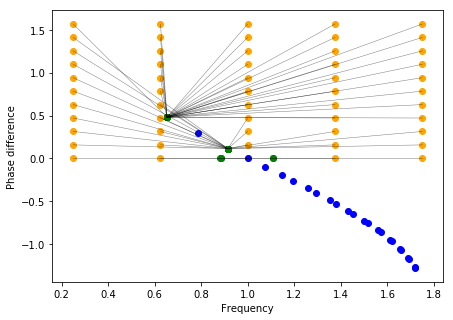

In [7]:
# Import arrays and values
dir_exfile = os.path.join(dir_ex, ex_name)
dict_ex = sio.loadmat(dir_exfile)

eq_freqs = np.reshape(dict_ex['eq_freqs'], -1)
eq_Deltas = np.reshape(dict_ex['eq_Deltas'], -1)
init_freqs = np.reshape(dict_ex['init_freqs'], -1)
init_Deltas = np.reshape(dict_ex['init_Deltas'], -1)
asy_freqs = np.reshape(dict_ex['asy_freqs'], -1)
asy_Deltas = np.reshape(dict_ex['asy_Deltas'], -1)

g = dict_ex['g'][0,0]
w0 = dict_ex['omega0'][0,0]

# Figure
fig, ax = plt.subplots(1, figsize=(7,5))

# Axis label
ax.set_xlabel('Frequency')
ax.set_ylabel('Phase difference')

# Dotted lines
dotopts = {'linestyle': '-',
           'linewidth': 0.5,
           'marker': None,
           'color': 'black',
           'alpha': 0.5
          }

for k in range(init_freqs.size):
    p1 = np.array([init_freqs[k], asy_freqs[k]])
    p2 = np.array([init_Deltas[k], asy_Deltas[k]])
    ax.plot(p1, p2, **dotopts)
    
ax.scatter(init_freqs, init_Deltas, color='orange')
ax.scatter(eq_freqs, eq_Deltas, color='blue')
ax.scatter(asy_freqs, asy_Deltas, color='green')
